In [2]:
import wfdb
from wfdb import processing
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib import figure
from scipy.fft import fft, ifft
from scipy import signal
import math
import seaborn as sns
import os

def load_data(path):
    """Načte soubor databáze a vrátí vzorky signálu EKG a seznam polí"""
    try:
        signals, fields = wfdb.rdsamp(path)
        ecg = signals[:, 0].flatten()
        ecg = high_pass_filter(ecg, fields["fs"])
        return ecg, fields
    
    except Exception as e:
        print(f"Chyba při načítání dat: {e}")
        return None, None
    

def high_pass_filter(signal, samp_rate, cutoff_freq=50):
    tau = 1 / (2 * np.pi * cutoff_freq)
    alpha = tau / (tau + 1 / (2 * np.pi * samp_rate))
    y_prev = 0
    x_prev = 0

    filtered_signal = []
    for x in signal:
        y = alpha * (y_prev + x - x_prev)
        filtered_signal.append(y)
        y_prev = y
        x_prev = x

    return np.array(filtered_signal)

def rectify_signal(signal):
    return np.abs(signal)

def integrate_signal(signal, window_size):
    return np.convolve(signal, np.ones(window_size), mode="same")

def detect_changes_in_signal(signal, window_size, threshold=0.001, do_plot=False):
    # Plot the input signal if specified
    if do_plot:
        plt.plot(signal[:signal.size - signal.size % window_size], color="#333F4B")

    # Initialize a list to store information about changes
    changes = []

    # Iterate over the signal with the specified window size
    for i in range(0, signal.size, window_size):
        window = signal[i:i + window_size]

        # Calculate the gradient of the window
        gradient_sum = np.sum(np.gradient(window))

        # Determine if the gradient sum exceeds the threshold
        is_rising = gradient_sum > threshold

        # Add information about the change to the list
        changes.append((i, i + window_size - 1, is_rising))

        # Plot colored spans if specified
        if do_plot:
            color = "#0fa821" if is_rising else "#a80f30"
            plt.axvspan(i, i + window_size - 1, color=color, alpha=0.5)

    return changes

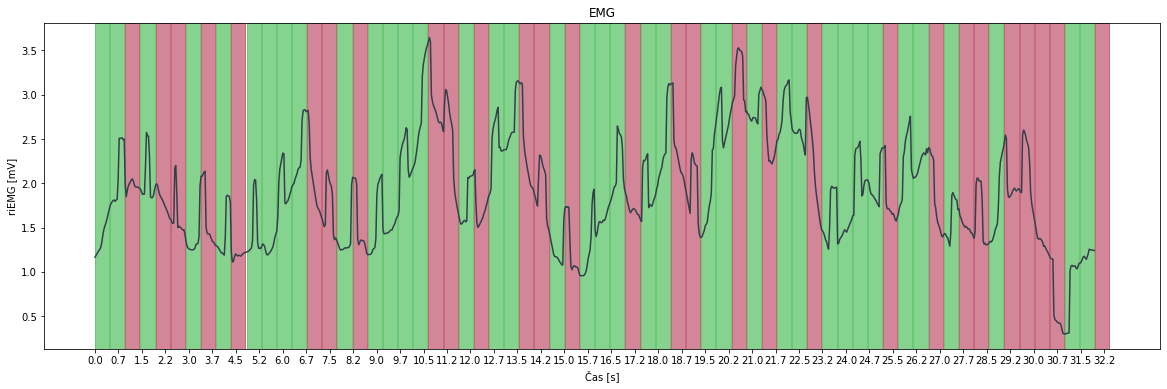

In [3]:
signal, signal_info = wfdb.rdsamp("Database/drive03")
signal = signal[:1000, 0]

rectified_signal = rectify_signal(signal)
integrated_signal = integrate_signal(rectified_signal, int(signal_info['fs']))

plt.figure(figsize=(20, 6))
plt.title("EMG")
plt.ylabel("riEMG [mV]")
plt.xlabel("Čas [s]")
plt.xticks(np.arange(0, len(signal), 60*12/signal_info['fs']), np.round(np.arange(0, len(signal), 60*12/signal_info['fs']) / signal_info['fs'], 1))

_ = detect_changes_in_signal(integrated_signal, int(signal_info['fs']/2), do_plot=True)
plt.show()

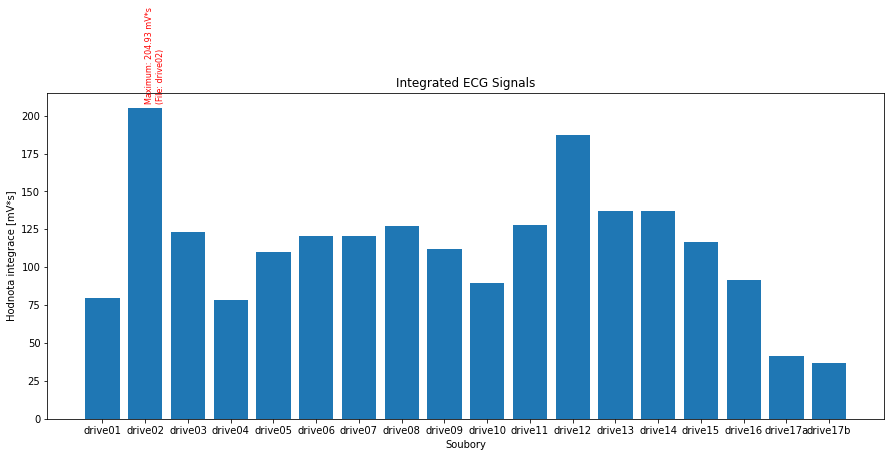

In [4]:
integrated_values = []
file_names = []

for file in os.listdir("Database"):
    if not file.endswith(".dat"):
        continue
    file_name = file[:-4]
    file_names.append(file_name)

    ecg, fields = wfdb.rdsamp(f"Database/{file_name}")
    ecg = ecg[:, 0]
    ecg = high_pass_filter(ecg, fields["fs"])

    # Použijte np.trapz k integraci signálu
    integrated_signal = np.trapz(np.abs(ecg), dx=1/fields['fs'])
    integrated_values.append(integrated_signal)

integrated_values = np.array(integrated_values)

max_integration_file = np.argmax(integrated_values)
max_integration_value = np.max(integrated_values)

plt.figure(figsize=(15, 6))
plt.title("Integrated ECG Signals")
plt.xlabel("Soubory")
plt.ylabel("Hodnota integrace [mV*s]")
plt.xticks(np.arange(len(integrated_values)), file_names)
plt.bar(np.arange(len(integrated_values)), integrated_values.flatten())
plt.text(max_integration_file, max_integration_value * 1.02, f"Maximum: {max_integration_value:.2f} mV*s\n(File: {file_names[max_integration_file]})", rotation=90, color="red", fontsize=8)
plt.show()